In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
train_emb1=torch.load('/content/drive/My Drive/Chalearn Data/UntunedKimCNN/first4k_data.pt')

In [3]:
train_emb2=torch.load('/content/drive/My Drive/Chalearn Data/UntunedKimCNN/second4k_data.pt')

In [4]:
train_emb=torch.cat((train_emb1,train_emb2),dim=0)

In [5]:
type(train_emb)

torch.Tensor

In [6]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/Chalearn Data/train-annotation.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')

In [7]:
from zipfile import ZipFile

zip_file = '/content/drive/My Drive/Chalearn Data/val-annotation-e.zip'
password = 'zeAzLQN7DnSIexQukc9W'

with ZipFile(zip_file) as zf:
  zf.extractall("/content/sample_data",pwd=bytes(password,'utf-8'))

In [8]:
from zipfile import ZipFile

zip_file = '/content/drive/My Drive/Chalearn Data/test-annotation-e.zip'
password = 'zeAzLQN7DnSIexQukc9W'

with ZipFile(zip_file) as zf:
  zf.extractall("/content/sample_data",pwd=bytes(password,'utf-8'))

In [9]:
df_train = pd.read_pickle('/content/sample_data/annotation_training.pkl')
df_val= pd.read_pickle('/content/sample_data/annotation_validation.pkl')

In [10]:
df_train = pd.DataFrame.from_dict(df_train)
df_val = pd.DataFrame.from_dict(df_val)

In [11]:
df_train=df_train.append(df_val,ignore_index=True)

In [12]:
df_test = pd.read_pickle('/content/sample_data/annotation_test.pkl')
df_test=pd.DataFrame.from_dict(df_test)
df_test=df_test.reset_index(drop=True)
df_test

,extraversion,neuroticism,agreeableness,conscientiousness,interview,openness
0,0.485981,0.645833,0.681319,0.669903,0.626168,0.822222
1,0.616822,0.593750,0.692308,0.514563,0.570093,0.655556
2,0.467290,0.625000,0.560440,0.524272,0.514019,0.522222
3,0.411215,0.458333,0.714286,0.660194,0.570093,0.400000
4,0.317757,0.437500,0.384615,0.524272,0.448598,0.411111
...,...,...,...,...,...,...
1995,0.289720,0.312500,0.208791,0.135922,0.177570,0.300000
1996,0.719626,0.781250,0.670330,0.572816,0.728972,0.722222
1997,0.355140,0.395833,0.472527,0.446602,0.411215,0.677778
1998,0.467290,0.645833,0.527473,0.669903,0.560748,0.622222


In [13]:
test_emb=torch.load('/content/drive/My Drive/Chalearn Data/test_embeddings.pt')

In [14]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [15]:
df_train

,extraversion,neuroticism,agreeableness,conscientiousness,interview,openness
0,0.523364,0.552083,0.626374,0.601942,0.504673,0.488889
1,0.345794,0.375000,0.472527,0.582524,0.457944,0.366667
2,0.252336,0.291667,0.406593,0.485437,0.373832,0.511111
3,0.457944,0.489583,0.505495,0.398058,0.457944,0.377778
4,0.607477,0.489583,0.406593,0.621359,0.570093,0.622222
...,...,...,...,...,...,...
7995,0.570093,0.614583,0.494505,0.689320,0.626168,0.577778
7996,0.542056,0.541667,0.549451,0.669903,0.579439,0.666667
7997,0.551402,0.593750,0.560440,0.572816,0.504673,0.644444
7998,0.514019,0.552083,0.461538,0.572816,0.551402,0.733333


In [16]:
y_train=df_train.loc[:,df_train.columns.values!='interview']
y_test=df_test.loc[:,df_test.columns.values!='interview']
y_train=torch.tensor(np.array(y_train)).type(torch.float32)
y_test=torch.tensor(np.array(y_test)).type(torch.float32)
y_train[0]

tensor([0.5234, 0.5521, 0.6264, 0.6019, 0.4889])

In [17]:
train = torch.utils.data.TensorDataset(train_emb,y_train)
test = torch.utils.data.TensorDataset(test_emb,y_test)

In [18]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train, batch_size = 64, shuffle = True)
test_loader = DataLoader(test, batch_size = 64, shuffle = True)

In [19]:
class MultiTaskLossWrapper(nn.Module):
  
  def __init__(self,model):
    super(MultiTaskLossWrapper, self).__init__()
    self.model = model
    self.log_vars = nn.Parameter(torch.zeros((5))).to(device)
    

  def forward(self, input, targets):
    output1,output2,output3,output4,output5 = self.model(input)
    #print(targets[:,0].shape)
    #print(np.array(outputs[:,0]))
    #print(output1.shape)
    precision1 = torch.exp(-self.log_vars[0])
    loss = torch.sum(precision1 * (targets[:,0] - output1) ** 2. + self.log_vars[0], -1)

    precision2 = torch.exp(-self.log_vars[1])
    loss += torch.sum(precision2 * (targets[:,1] - output2) ** 2. + self.log_vars[1], -1)

    precision3 = torch.exp(-self.log_vars[2])
    loss += torch.sum(precision3 * (targets[:,2] - output3) ** 2. + self.log_vars[2], -1)

    precision4 = torch.exp(-self.log_vars[3])
    loss += torch.sum(precision4 * (targets[:,3] - output4) ** 2. + self.log_vars[3], -1)

    precision5 = torch.exp(-self.log_vars[4])
    loss += torch.sum(precision5 * (targets[:,4] - output5) ** 2. + self.log_vars[4], -1)

    loss = torch.mean(loss)

    return loss, self.log_vars.data.tolist()


In [20]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv0=nn.Conv2d(in_channels=1,out_channels=100,kernel_size=(2,768))
    self.conv1=nn.Conv2d(in_channels=1,out_channels=100,kernel_size=(3,768))
    self.conv2=nn.Conv2d(in_channels=1,out_channels=100,kernel_size=(4,768))
    self.conv3=nn.Conv2d(in_channels=1,out_channels=100,kernel_size=(5,768))
    self.fc1=nn.Linear(400,128)
    self.fc2=nn.Linear(128,36)
    self.fc21=nn.Linear(36,1)
    self.fc22=nn.Linear(36,1)
    self.fc23=nn.Linear(36,1)
    self.fc24=nn.Linear(36,1)
    self.fc25=nn.Linear(36,1)
    self.dropout=nn.Dropout(p=0.2)

  def forward(self,x):
      x = x.unsqueeze(1)
      x0=F.leaky_relu(self.conv0(x)).squeeze(3)
      x1=F.leaky_relu(self.conv1(x)).squeeze(3)
      x2=F.leaky_relu(self.conv2(x)).squeeze(3)
      x3=F.leaky_relu(self.conv3(x)).squeeze(3)
      x0=F.max_pool1d(x0,x0.size(2))
      x1=F.max_pool1d(x1,x1.size(2))
      x2=F.max_pool1d(x2,x2.size(2))
      x3=F.max_pool1d(x3,x3.size(2))
      x=torch.cat((x0.squeeze(dim=2),x1.squeeze(dim=2),x2.squeeze(dim=2),x3.squeeze(dim=2)),dim=1)
      x=self.fc1(x)
      x=self.fc2(x)
      x11=self.fc21(x)
      x12=self.fc22(x)
      x13=self.fc23(x)
      x14=self.fc24(x)
      x15=self.fc25(x)
      return x11,x12,x13,x14,x15

In [ ]:
#Squeeze adds 1, Unsqueeze removes 1

In [21]:
model=Network()
model.cuda()

Network(
  (conv0): Conv2d(1, 100, kernel_size=(2, 768), stride=(1, 1))
  (conv1): Conv2d(1, 100, kernel_size=(3, 768), stride=(1, 1))
  (conv2): Conv2d(1, 100, kernel_size=(4, 768), stride=(1, 1))
  (conv3): Conv2d(1, 100, kernel_size=(5, 768), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
  (fc21): Linear(in_features=36, out_features=1, bias=True)
  (fc22): Linear(in_features=36, out_features=1, bias=True)
  (fc23): Linear(in_features=36, out_features=1, bias=True)
  (fc24): Linear(in_features=36, out_features=1, bias=True)
  (fc25): Linear(in_features=36, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [22]:
mtl=MultiTaskLossWrapper(model)

In [23]:
mtl

MultiTaskLossWrapper(
  (model): Network(
    (conv0): Conv2d(1, 100, kernel_size=(2, 768), stride=(1, 1))
    (conv1): Conv2d(1, 100, kernel_size=(3, 768), stride=(1, 1))
    (conv2): Conv2d(1, 100, kernel_size=(4, 768), stride=(1, 1))
    (conv3): Conv2d(1, 100, kernel_size=(5, 768), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=36, bias=True)
    (fc21): Linear(in_features=36, out_features=1, bias=True)
    (fc22): Linear(in_features=36, out_features=1, bias=True)
    (fc23): Linear(in_features=36, out_features=1, bias=True)
    (fc24): Linear(in_features=36, out_features=1, bias=True)
    (fc25): Linear(in_features=36, out_features=1, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [24]:
lr=0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_list=[]
epochs=45
for i in range(epochs):
  model.train(True)
  running_loss=0
  for emb,label in train_loader:
    emb1=emb.to(device)
    label1=label.to(device)
    loss,lag_vars=mtl(emb1,label1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  else:
    print(f"Training loss: {running_loss/len(train_loader)}")
    loss_list.append(running_loss/len(train_loader))

Training loss: 10.885229545593262
Training loss: 7.281649112701416
Training loss: 7.354980922698974
Training loss: 7.424922649383545
Training loss: 7.326601879119873
Training loss: 7.3015951194763185
Training loss: 7.448439708709717
Training loss: 7.251922271728516
Training loss: 7.285950199127197
Training loss: 7.26570565032959
Training loss: 7.288456966400147
Training loss: 7.18046717453003
Training loss: 7.313581329345703
Training loss: 7.208598052978515
Training loss: 7.1807662239074705
Training loss: 7.176923290252685
Training loss: 7.153190547943115
Training loss: 7.180619640350342
Training loss: 7.2904251823425295
Training loss: 7.2198797111511235
Training loss: 7.163327068328857
Training loss: 7.093245365142822
Training loss: 7.159063514709473
Training loss: 7.162267395019532
Training loss: 7.158468521118164
Training loss: 7.140469268798828
Training loss: 7.114339782714843
Training loss: 7.117068958282471
Training loss: 7.1561006164550784
Training loss: 7.141621181488037
Traini

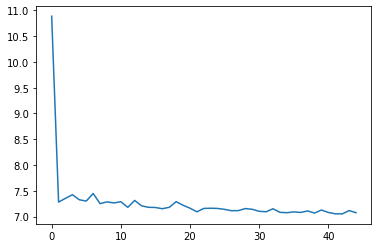

In [25]:
import pylab
pylab.plot(loss_list)
pylab.show()

In [ ]:
m1=m1.reshape(64,1,3)
m2=F.max_pool1d(m1,m1.size(2))
m2.shape

torch.Size([64, 1, 1])

In [26]:
#print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions1=[]
predictions2=[]
predictions3=[]
predictions4=[]
predictions5=[]
true1=[]
true2=[]
true3=[]
true4=[]
true5=[]
# Predict 
for emb,label in test_loader:


  # Add batch to GPU
  #batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  #b_input_ids, b_input_mask, b_labels = batch
  emb1=emb.to(device)
  label1=label.to(device)

  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      output1,output2,output3,output4,output5 = model.forward(emb1)

  logits1 = output1
  logits2 = output2
  logits3 = output3
  logits4 = output4
  logits5 = output5
  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  logits2 = logits2.detach().cpu().numpy()
  logits3 = logits3.detach().cpu().numpy()
  logits4 = logits4.detach().cpu().numpy()
  logits5 = logits5.detach().cpu().numpy()
  predictions1.append(logits1)
  predictions2.append(logits2)
  predictions3.append(logits3)
  predictions4.append(logits4)
  predictions5.append(logits5)
  label_ids1 = label1[:,0].to('cpu').numpy()
  label_ids2 = label1[:,1].to('cpu').numpy()
  label_ids3 = label1[:,2].to('cpu').numpy()
  label_ids4 = label1[:,3].to('cpu').numpy()
  label_ids5 = label1[:,4].to('cpu').numpy()
  # Store predictions and true labels
  #predictions.append(logits)
  true1.append(label_ids1)
  true2.append(label_ids2)
  true3.append(label_ids3)
  true4.append(label_ids4)
  true5.append(label_ids5)

print('    DONE.')


    DONE.


In [27]:
predictions11=[]
for i in range(len(predictions1)):
  for j in range(len(predictions1[i])):
    predictions11.append(predictions1[i][j])


In [28]:
predictions12=[]
for i in range(len(predictions2)):
  for j in range(len(predictions2[i])):
    predictions12.append(predictions2[i][j])


In [29]:
predictions13=[]
for i in range(len(predictions3)):
  for j in range(len(predictions3[i])):
    predictions13.append(predictions3[i][j])


In [30]:
predictions14=[]
for i in range(len(predictions4)):
  for j in range(len(predictions4[i])):
    predictions14.append(predictions4[i][j])


In [31]:
predictions15=[]
for i in range(len(predictions5)):
  for j in range(len(predictions5[i])):
    predictions15.append(predictions5[i][j])


In [32]:
true_labels1=[]
for i in range(len(true1)):
  for j in range(len(true1[i])):
    true_labels1.append(true1[i][j])

In [33]:
true_labels2=[]
for i in range(len(true2)):
  for j in range(len(true2[i])):
    true_labels2.append(true2[i][j])

In [34]:
true_labels3=[]
for i in range(len(true3)):
  for j in range(len(true3[i])):
    true_labels3.append(true3[i][j])

In [35]:
true_labels4=[]
for i in range(len(true4)):
  for j in range(len(true4[i])):
    true_labels4.append(true4[i][j])

In [36]:
true_labels5=[]
for i in range(len(true5)):
  for j in range(len(true5[i])):
    true_labels5.append(true5[i][j])

In [37]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(true_labels1, predictions11))  #E
print(mean_absolute_error(true_labels2, predictions12))  #N
print(mean_absolute_error(true_labels3, predictions13))  #A
print(mean_absolute_error(true_labels4, predictions14))  #C
print(mean_absolute_error(true_labels5, predictions15))  #O

0.12294203
0.12389897
0.106497794
0.1255402
0.11770703


In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(true_labels1, predictions11))  #E
print(mean_squared_error(true_labels2, predictions12))  #N
print(mean_squared_error(true_labels3, predictions13))  #A
print(mean_squared_error(true_labels4, predictions14))  #C
print(mean_squared_error(true_labels5, predictions15))  #O

0.022533882
0.023529643
0.01777381
0.023285568
0.020939764


(64, 1)